In [1]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
import gensim
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.util import get_root_path
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from src.data.preprocessing import Preprocessor
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import spacy

nltk.download('punkt')
pre = Preprocessor()

[nltk_data] Downloading package punkt to /Users/max/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/max/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/max/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/max/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv(os.path.join(get_root_path(), "data", "raw", "test.csv"))
# some basic text cleaning
df["clean_text"] = df["text"].str.lower()
df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_html(x))
df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_urls(x))
df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_emoticons(x))
df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_special_characters(x))
df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_digits(x))

In [3]:
# some further preprocessing
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
df["clean_text"] = df["clean_text"].map(lambda x: pre.lem_words(x, lemmatizer, wordnet_map))
# remove empty columns
df = df[df["clean_text"].map(len) > 0]
# df.drop(df[df.clean_text.map(lambda x: len(x)) == 0].index)

In [18]:
df.tail()

,id,keyword,location,text,clean_text
3258,10861,NAN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fastener ...
3259,10865,NAN,NaN,Storm in RI worse than last hurricane. My city...,storm in ri bad than last hurricane my city am...
3260,10868,NAN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment in chicago
3261,10874,NAN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo
3262,10875,NAN,NaN,#CityofCalgary has activated its Municipal Eme...,cityofcalgary have activate it municipal emerg...


In [17]:
df.keyword.fillna("NAN",inplace=True)

33.0
100.0


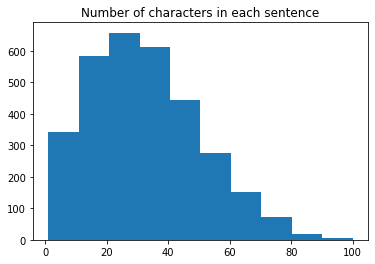

In [288]:
num_char = df["clean_text"].str.len()
print(np.ceil(np.mean(num_char)))
print(np.ceil(np.max(num_char)))
plt.hist(num_char)
plt.title("Number of characters in each sentence")
plt.show()

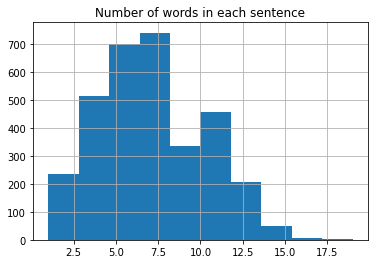

In [184]:
df["clean_text"].str.split().map(lambda x: len(x)).hist()
plt.title("Number of words in each sentence")
plt.show()

6.0
19.0


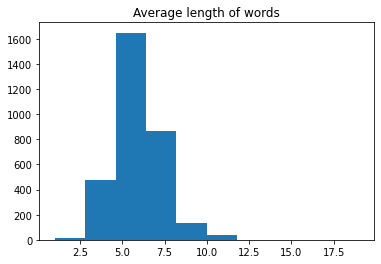

In [289]:
avg_len_words = df["clean_text"].str.split().map(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
print(np.ceil((np.mean(avg_len_words))))
print(np.ceil((np.max(avg_len_words))))
plt.hist(avg_len_words)
plt.title("Average length of words")
plt.show()

In [220]:
nltk.download("stopwords")
stop = set(nltk.corpus.stopwords.words("english"))
# remove stopwords

df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_stopwords(x))
df = df[df["clean_text"].map(len) > 0]
df["clean_text"].head()

[nltk_data] Downloading package stopwords to /Users/max/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                         terrible
1    heard earthquake different stay safe everyone
2        spot pond geese flee across street cannot
3                         apocalypse light spokane
4                    typhoon soudelor china taiwan
Name: clean_text, dtype: object

In [221]:
text = df["clean_text"].str.split()
text = text.values.tolist()
corpus = [word for i in text for word in i]

In [222]:
dic = defaultdict(int)
for word in corpus:
    if word not in stop:
        dic[word] += 1

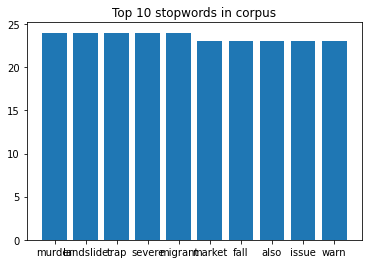

In [223]:
top_stopwords = sorted(dic.items(), key=lambda item: item[1], reverse=True)[:10]
x, y = zip(*top_stopwords)
plt.bar(x, y)
plt.title("Top 10 stopwords in corpus")
plt.show()

In [224]:
counter = Counter(corpus)
most_common = counter.most_common()
x, y = [], []
for word, count in most_common[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

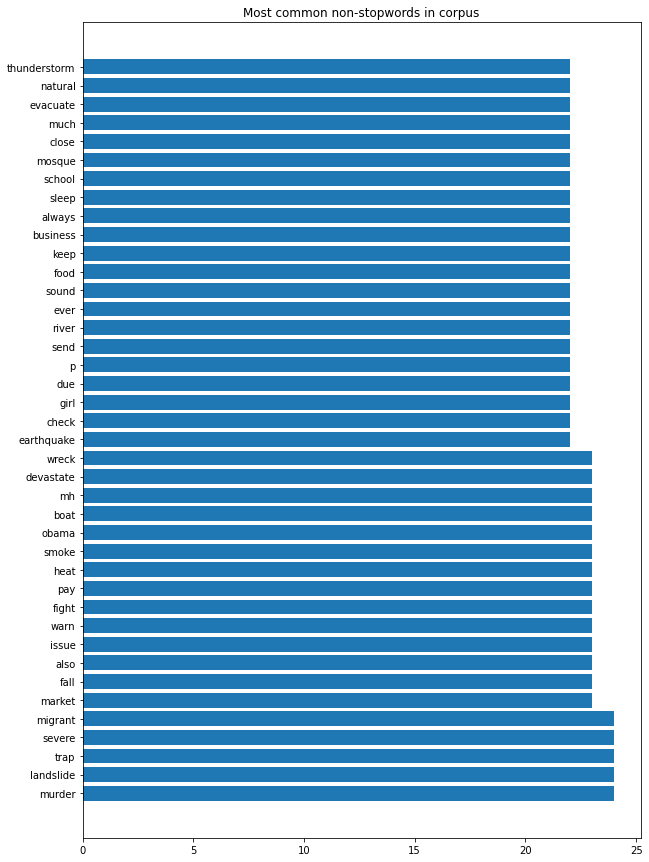

In [225]:
plt.figure(figsize=(10,15))
plt.barh(x, y)
plt.title("Most common non-stopwords in corpus")
plt.show()

In [226]:
least_common = most_common[::-1]
x, y = [], []
for word, count in least_common[:40]:
    if count > 2:
        x.append(word)
        y.append(count)

In [227]:
# ngram exploration
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:20]

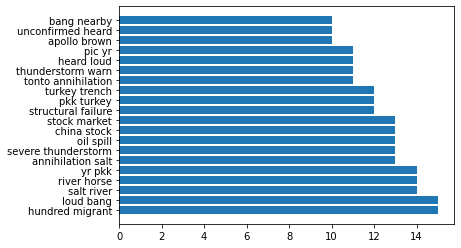

In [228]:
top_n_bigrams=get_top_ngram(df["clean_text"],2)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.barh(x, y)
plt.show()

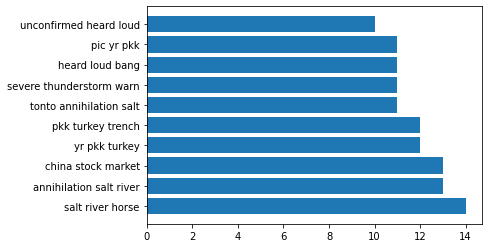

In [229]:
top_n_trigrams=get_top_ngram(df["clean_text"],3)[:10]
x,y=map(list,zip(*top_n_trigrams))
plt.barh(x, y)
plt.show()

In [230]:
# remove frequent and rare words
freq = list(dict(most_common).keys())[:100]
least = list(dict(least_common).keys())[:1000]
df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_freqwords(x, freq))
df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_rarewords(x, least))

/var/folders/1f/rnx0xy3n5xz0rnz4kdpzrkbm0000gn/T/ipykernel_59217/1603828265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_freqwords(x, freq))
/var/folders/1f/rnx0xy3n5xz0rnz4kdpzrkbm0000gn/T/ipykernel_59217/1603828265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_text"] = df["clean_text"].map(lambda x: pre.remove_rarewords(x, least))


# Topic Modelling

In [231]:
corpus = [words.split() for words in df["clean_text"]]
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [232]:
%%time
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=3,
                                       id2word=dic,
                                       passes=10,
                                       workers=4)
lda_model.show_topics()

CPU times: user 5.23 s, sys: 690 ms, total: 5.91 s
Wall time: 11.5 s


[(0,
  '0.003*"detonation" + 0.003*"horse" + 0.003*"bang" + 0.003*"salt" + 0.003*"must" + 0.003*"heard" + 0.003*"rescuer" + 0.002*"pkk" + 0.002*"though" + 0.002*"turkey"'),
 (1,
  '0.003*"calgary" + 0.002*"terrorism" + 0.002*"hailstorm" + 0.002*"stretcher" + 0.002*"rainstorm" + 0.002*"affect" + 0.002*"hail" + 0.002*"dust" + 0.002*"self" + 0.002*"security"'),
 (2,
  '0.003*"military" + 0.003*"lava" + 0.003*"flatten" + 0.003*"whole" + 0.002*"rise" + 0.002*"airport" + 0.002*"effect" + 0.002*"confirm" + 0.002*"structural" + 0.002*"swallow"')]

# Wordcloud

In [233]:
stopwords = STOPWORDS

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color="white",
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1,
    )
    wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

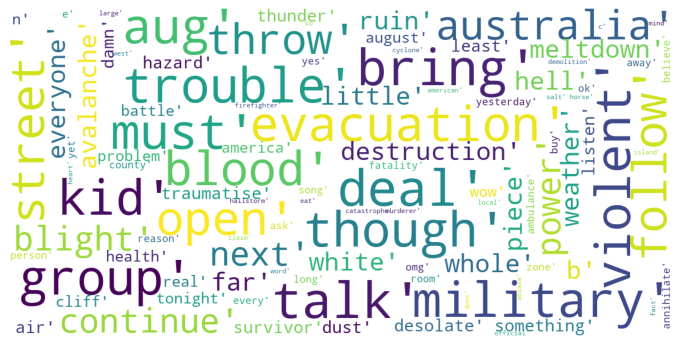

In [234]:
show_wordcloud(corpus)

# Sentiment Analysis

In [235]:
# using textblob model
def polarity(text):
    return TextBlob(text).sentiment.polarity

/var/folders/1f/rnx0xy3n5xz0rnz4kdpzrkbm0000gn/T/ipykernel_59217/3521170312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["polarity_score"] = df["clean_text"].map(lambda x: polarity(x))


<AxesSubplot:>

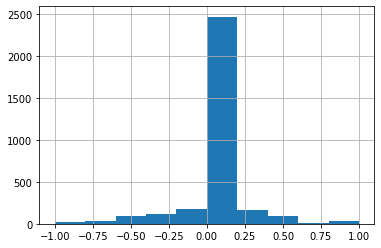

In [236]:
df["polarity_score"] = df["clean_text"].map(lambda x: polarity(x))
df["polarity_score"].hist()

In [237]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'

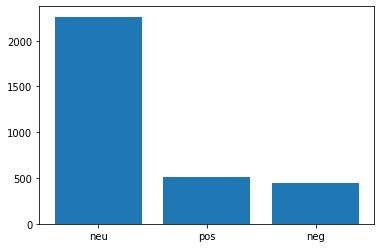

In [238]:
df["polarity"] = df["polarity_score"].map(lambda x: sentiment(x))
plt.bar(df.polarity.value_counts().index, df.polarity.value_counts())
plt.show()

In [239]:
df[df["polarity"] == "pos"]["clean_text"].head(10)

1                    heard different stay safe everyone
8                                              nice hat
14                                              awesome
32    recorder zeroedge dual lens camera vehicle tra...
35    en pretend certain become genuine hei darker m...
36           legal medical referral slipandfall dogbite
37             construction disney store huge gauge ear
40                                meet super jelly dave
46    schoolboy aftershock original mix excision ski...
56              bo far competitive imo bo invahnwetrust
Name: clean_text, dtype: object

In [240]:
df[df["polarity"] == "neg"]["clean_text"].head(10)

0                                              terrible
10                                                 cold
23                            rape victim ablaze ablaze
28                                    hurt ablaze anger
29    clear paturnpike patp eb pa cranberry slow tra...
31                                         hate badging
33                  coincidence curse unresolved secret
41       cold block se vista ter gresham gresham pg pdx
50                                         wish unknown
60       carelessness aviation victim seek compensation
Name: clean_text, dtype: object

# NER

In [241]:
nlp = spacy.load("en_core_web_sm")
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent = df["clean_text"].map(lambda x: ner(x))
ent = [x for sub in ent for x in sub]
counter = Counter(ent)
count = counter.most_common()

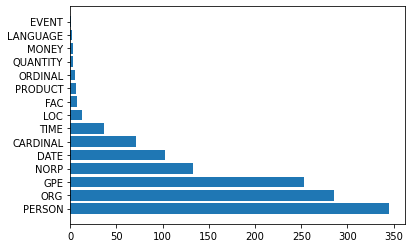

In [242]:
x, y = map(list, zip(*count))
plt.barh(x, y)
plt.show()

In [243]:
def ner(text, ent="GPE"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = df["clean_text"].map(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

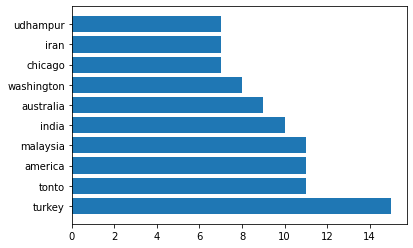

In [244]:
x, y = map(list, zip(*counter.most_common(10)))
plt.barh(x, y)
plt.show()

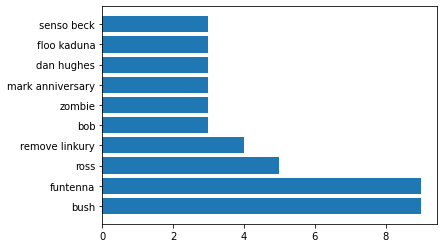

In [245]:
gpe = df["clean_text"].map(lambda x: ner(x, "PERSON"))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)
x, y = map(list, zip(*counter.most_common(10)))
plt.barh(x, y)
plt.show()

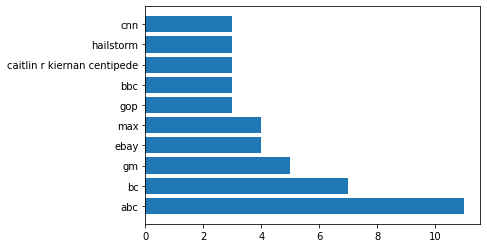

In [246]:
gpe = df["clean_text"].map(lambda x: ner(x, "ORG"))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)
x, y = map(list, zip(*counter.most_common(10)))
plt.barh(x, y)
plt.show()

# POS

In [256]:
def pos(text):
    pos = nltk.pos_tag(word_tokenize(text))
    return list(map(list,zip(*pos)))[-1]

In [267]:
df = df[df["clean_text"].map(len) > 0]
tags = df["clean_text"].map(lambda x: pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

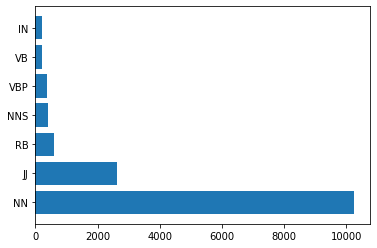

In [261]:
x, y = list(map(list, zip(*counter.most_common(7))))
plt.barh(x, y)
plt.show()

In [281]:
p = (counter["NN"]+counter["JJ"])/sum(counter.values())*100
print(f"NN and JJ make up {p:.4}% of the words")

NN and JJ make up 83.79% of the words


In [262]:
def get_adjs(text, tag="NN"):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag_ in pos:
        if tag_==tag:
            adj.append(word)
    return adj

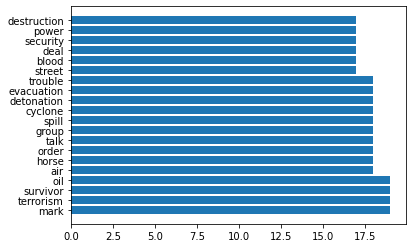

In [263]:
words = df["clean_text"].map(lambda x: get_adjs(x, "NN"))
words = [x for l in words for x in l]
counter = Counter(words)

x, y = list(map(list, zip(*counter.most_common(20))))
plt.barh(x, y)
plt.show()

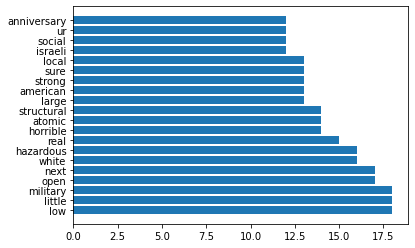

In [264]:
words = df["clean_text"].map(lambda x: get_adjs(x, "JJ"))
words = [x for l in words for x in l]
counter = Counter(words)

x, y = list(map(list, zip(*counter.most_common(20))))
plt.barh(x, y)
plt.show()

In [172]:
len(np.where(pd.isnull(df["keyword"]))[0])

26

In [169]:
a = df["clean_text"].map(lambda x: len(x)==0)

In [170]:
a.sum()

11